In [28]:
import json

with open('./trec-covid-suc-d2d-retrieval.jsonl', 'r') as f:
    suc_js = [json.loads(file) for file in f.readlines()]

with open('./trec-covid-fail-d2d-retrieval.jsonl', 'r') as f:
    fail_js = [json.loads(file) for file in f.readlines()]

In [31]:
len(fail_js)

380

In [32]:
from itertools import combinations

def generate_pairs(n_aug, n_sample):
    # total items: n_aug * n_sample
    total_items = n_aug * n_sample
    
    # save all pairs
    all_pairs = []
    
    for i in range(0, total_items, n_aug):
        group = list(range(i, i + n_aug))
        pairs = list(combinations(group, 2))
        all_pairs.extend(pairs)
    
    return all_pairs

In [33]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

def rbo(list1, list2, p=0.9):
    overlap = 0
    rbo_score = 0
    weight = 1
    depth = min(len(list1), len(list2))
    
    for d in range(depth):
        if list1[d] == list2[d]:
            overlap += 1
        rbo_score += overlap / (d + 1) * (p ** d)
        weight *= p

    return (1 - p) * rbo_score

def spearman_rank_correlation(list1, list2):
    return spearmanr(list1, list2).correlation

# Example function to calculate Kendall's Tau with ties
def kendalls_tau_with_ties(list1, list2):
    tau, p_value = kendalltau(list1, list2)
    return tau

n_aug = 10

def get_rbo_score(js):
    total_list = [[ret['seq_num'] for ret in js[i]['retrieval']] for i in range(len(js))]
    rbo_scores = []
    assert len(total_list) % n_aug == 0
    n_sample = len(total_list) // n_aug
    
    pairs = generate_pairs(n_aug, n_sample)
    for i, j in pairs:
        rbo_scores.append(rbo(total_list[i], total_list[j]))

    mean_scores = []
    
    n_n1_2 = n_aug * (n_aug-1) // 2

    for i in range(0, len(pairs), n_n1_2):
        mean_scores.append(sum(rbo_scores[i:i+n_n1_2]) / n_n1_2)

    return mean_scores

def get_spearman_score(js):
    total_list = [[ret['seq_num'] for ret in js[i]['retrieval']] for i in range(len(js))]
    spearman_scores = []
    pairs = generate_pairs(n_aug, n_sample)
    for i, j in pairs:
        spearman_scores.append(spearman_rank_correlation(total_list[i], total_list[j]))

    print(sum(spearman_scores) / len(spearman_scores))

def get_tau_score(js):
    total_list = [[ret['seq_num'] for ret in js[i]['retrieval']] for i in range(len(js))]
    tau_scores = []
    pairs = generate_pairs(n_aug, n_sample)
    for i, j in pairs:
        tau_scores.append(kendalls_tau_with_ties(total_list[i], total_list[j]))

    print(sum(tau_scores) / len(tau_scores))

In [34]:
suc_list = get_rbo_score(suc_js)
fail_list = get_rbo_score(fail_js)

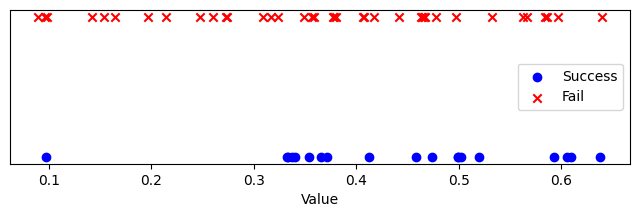

In [35]:
from matplotlib import pyplot as plt

# Plotting the lists as points in a 1D space
plt.figure(figsize=(8, 2))

# Plotting the points for each list along a 1D line
plt.scatter(suc_list, [1]*len(suc_list), label='Success', color='blue', marker='o')
plt.scatter(fail_list, [2]*len(fail_list), label='Fail', color='red', marker='x')

# Removing y-axis since it's a 1D plot
plt.yticks([])

# Adding labels and legend
plt.xlabel('Value')
plt.legend()

# Display the plot
plt.show()

In [36]:
print(sum(suc_list) / len(suc_list))
print(sum(fail_list) / len(fail_list))

0.43900863877176294
0.36671216966884196
